In [4]:
import os
#%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
plt.style.use('seaborn-v0_8-deep')

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    #"font.size"   : 15,
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

LABELS = ["sgd", "rmiso", "adam", "mcsag", "adagrad", "sgd_lr_decay"]

In [5]:
def get_folder_path(use_pretrained=True):
    path = 'curve'
    if use_pretrained:
        path = os.path.join(path, 'pretrained')
    return path

In [6]:
def get_curve_data(use_pretrained=True, model='one_layer'):
    folder_path = get_folder_path(use_pretrained)
    filenames = [name for name in os.listdir(folder_path) if name.startswith(model.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    optims = [name.split('-')[1] for name in filenames]
    lrs = [float(name.split('-')[2][2:]) for name in filenames]
    algs = [name.split('-')[-1] for name in filenames]
    nodes = [int(name.split('-')[-5][6:]) for name in filenames]
    edges = [int(name.split('-')[-4][6:]) for name in filenames]
    hyperparams = [name.split('-')[3:-5] for name in filenames]
    return [{"optim": op, "lr": l, "alg": alg, "hyp_params": hp, "nodes": nodes, "edges": edges, "curve": torch.load(fp)}
            for op, l, alg, hp, nodes, edges, fp in zip(optims, lrs, algs, hyperparams, nodes, edges, paths)]

In [7]:
def order_labels(labels, handels):
    i = 0
    while not labels[i].startswith("RMISO"):
        i += 1
    temp_l, temp_h = labels[0], handels[0]
    labels[0], handels[0] = labels[i], handels[i]
    labels[i], handels[i] = temp_l, temp_h
            
        
    return handels, labels

In [8]:
def plot(use_pretrained=True, model='one_layer', optimizers=None, title=None, ylim=(60, 80), curve_type='train',
         algorithm='uniform', display_hyperparams=False):
    assert model in ['one_layer', 'two_layer'], 'Invalid model name: {}'.format(model)
    assert curve_type in ['train_acc', 'test_acc', 'train_loss', 'test_loss'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    curve_data = get_curve_data(use_pretrained, model=model)
    
    #plt.figure()
    fig, ax = plt.subplots(sharex=True, sharey=True)
    if curve_type.split("_")[1] == "acc":
        if title is None:
            title = '{} Accurcy for {} on covertype'.format(curve_type.split("_")[0].capitalize(), model)
        plt.ylabel('{} Accuracy %'.format(curve_type.split("_")[0].capitalize()))
    else:
        if title is None:
            title = '{} Loss for {} on covertype'.format(curve_type.split("_")[0].capitalize(), model)
        plt.ylabel('{} Loss'.format(curve_type.split("_")[0].capitalize()))

    #plt.title(title)
    plt.xlabel('Iterations')
    #plt.xlim(0, 100)
    plt.ylim(ylim)
    
    for curve in curve_data:
        optim = curve['optim']
        lr = curve['lr']
        alg = curve['alg']
        
        if optim == "rmiso" or optim == "mcsag":
            delta = curve['hyp_params'][1][5:]
            rho = curve['hyp_params'][0][3:]
            
        #if optim == "mcsag" and float(delta) != 1:
            #continue
        
        linestyle = '-' if 'rmiso' in optim else '-'
        marker = 'o' if 'rmiso' in optim else ''
        if 'SMM' in optim:
            marker = '*'
        
        if optim in optimizers.keys() and lr in optimizers[optim] and alg == algorithm:
            accuracies = np.array(curve['curve'][curve_type])
            n_iterations = np.array(curve['curve']['iter_count'])
            if optim == "rmiso":
                color = '#dd8452'
                L = 1/lr
                label = r"RMISO: L={}, $\beta={}$".format(L, delta) if display_hyperparams else "RMISO"
            elif optim == "sgd":
                label = "SGD-HB: lr={}".format(lr) if display_hyperparams else "SGD-HB"
            elif optim == "sgd_lr_decay":
                label = "SGD: lr={}".format(lr) if display_hyperparams else "SGD"
            elif optim =="mcsag":
                if alg == 'uniform':
                    label = "SAG-lr: {}".format(lr)
                else:
                    delta = curve['hyp_params'][1][5:]
                    label = r'MCSAG-lr: {}, $\beta={}$'.format(lr, delta) if display_hyperparams else "MCSAG"
            else:
                label = f"{optim.upper()}, lr={lr}" if display_hyperparams else f"{optim.upper()}"
            if optim == "rmiso":
                if float(delta) == 1e-5:
                    ax.plot(n_iterations, accuracies, label=label, ls=linestyle, marker=marker, markevery=5, color=color, zorder=1)
                else:
                    pass
            else:
                ax.plot(n_iterations, accuracies, label=label, ls=linestyle, marker=marker, markevery=5, zorder=0)
                
        

        
    plt.grid(ls='--')
    handles,labels = plt.gca().get_legend_handles_labels()
    handles, labels = order_labels(labels, handles)
    plt.legend(handles, labels, ncol=2)
    #plt.show()
    save_name = "{}_{}_{}".format(model, curve_type, algorithm)+".jpg" 
    path = os.path.join(os.getcwd(), 'figs')
    os.makedirs(path, exist_ok=True)
    f_name = os.path.join(path, save_name)
    #plt.savefig(f_name, bbox_inches="tight")

## One Layer Model - MCMC

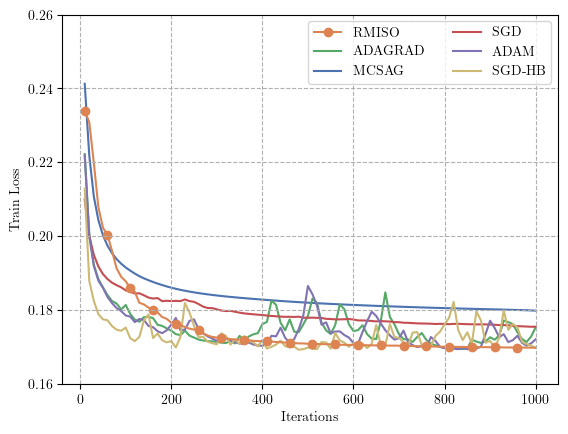

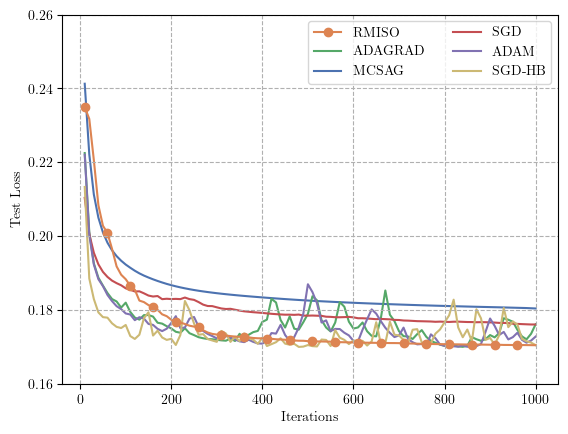

In [10]:
optimizers = {"rmiso": [20], "sgd": [0.1], "sgd_lr_decay": [1], 'mcsag':[3], 'adam': [0.01], "adagrad": [0.1]}

plot(use_pretrained=False, model='one_layer',
     title=title_test, optimizers=optimizers, ylim=(0.16, 0.26), curve_type='train_loss', algorithm="metropolis_hastings")
plot(use_pretrained=False, model='one_layer',
     title=title_test, optimizers=optimizers, ylim=(0.16, 0.26), curve_type='test_loss', algorithm="metropolis_hastings")

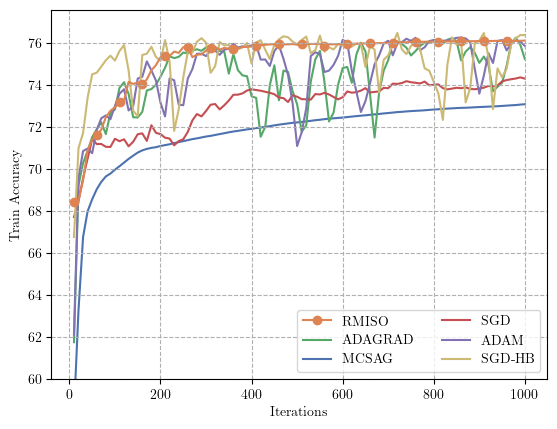

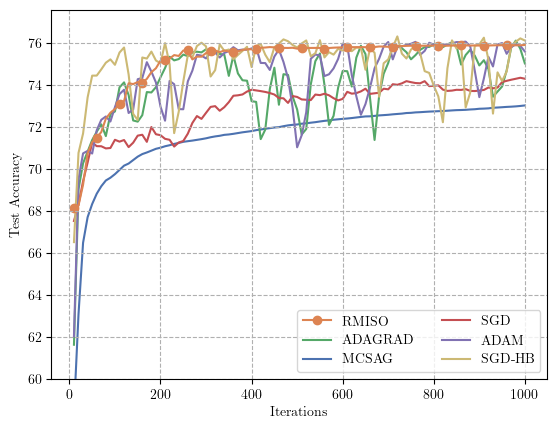

In [52]:
optimizers = {"rmiso": [20], "sgd": [0.1], "sgd_lr_decay": [1], 'mcsag':[3], 'adam': [0.01], "adagrad": [0.1]}

plot(use_pretrained=False, model='one_layer', 
     title=None, optimizers=optimizers, curve_type='train_acc', ylim=(60, 77.6), algorithm="metropolis_hastings")
plot(use_pretrained=False, model='one_layer',
     title=None, optimizers=optimizers, curve_type='test_acc', ylim=(60, 77.6), algorithm="metropolis_hastings")

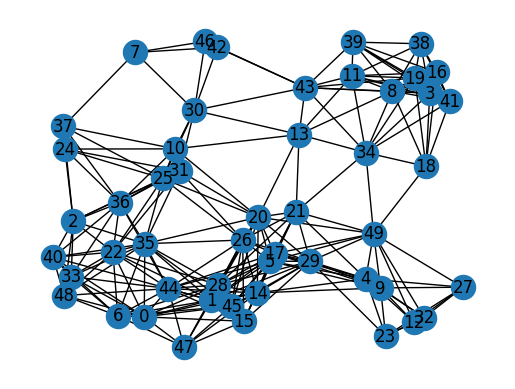

In [1]:
from graph_structure.data_graph import plot_graph
fig, ax = plot_graph(nodes=50, radius=0.3, topo='geometric')